In [409]:
#MULTIPLE LINEAR REGRESSION - METHOD 1 - MECHANICALLY CONSISTENT

Number of training samples: 79
Number of validation samples: 26
Number of test samples: 27

Evaluation Metrics (Production Approach):
              Set   MSE  RMSE  MPAE (%)     R  R-squared
0      Validation  4.31  2.08     24.55  0.68       0.45
1            Test  3.55  1.88     31.64  0.85       0.64
2  Entire Dataset  3.52  1.88     28.60  0.79       0.52

Final Equation:
V_j = [gamma * 1.530 * (1 + 0.3 * n) * sigcc + 0.157 * RI * sigcc / jar + gamma * 0.634 * fy * rogross]


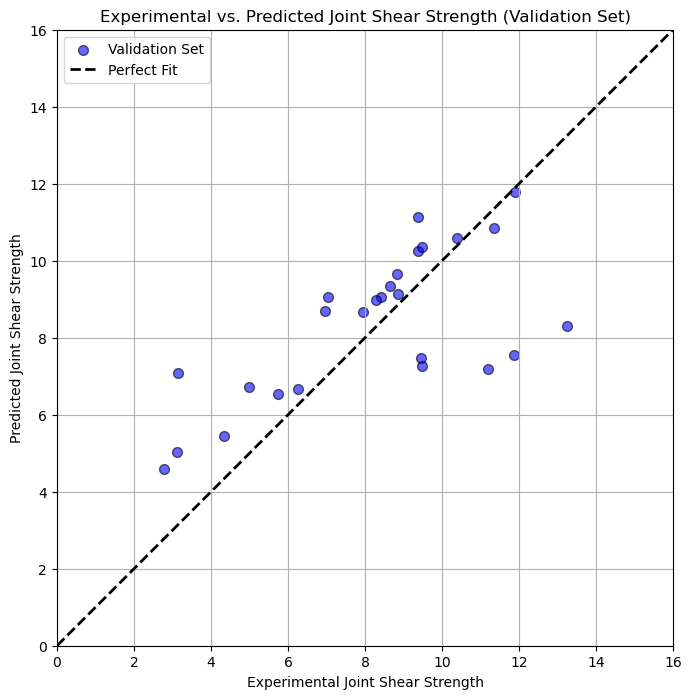

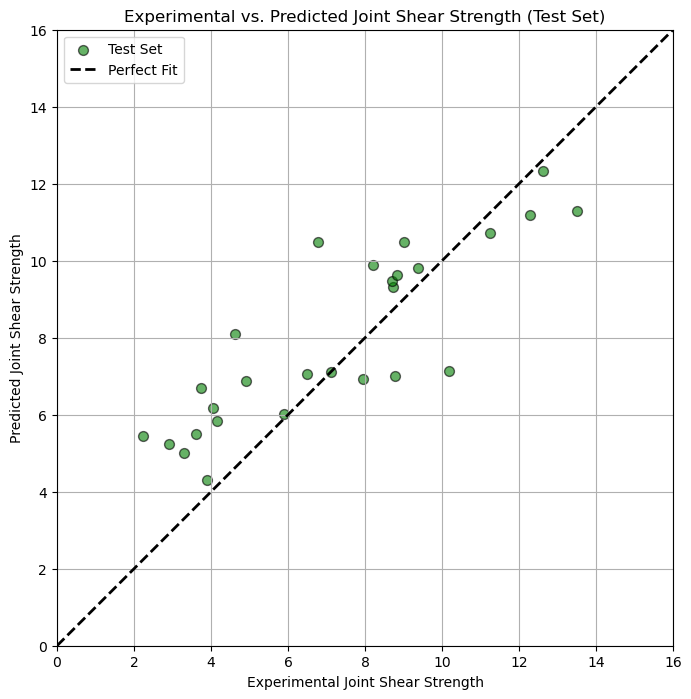

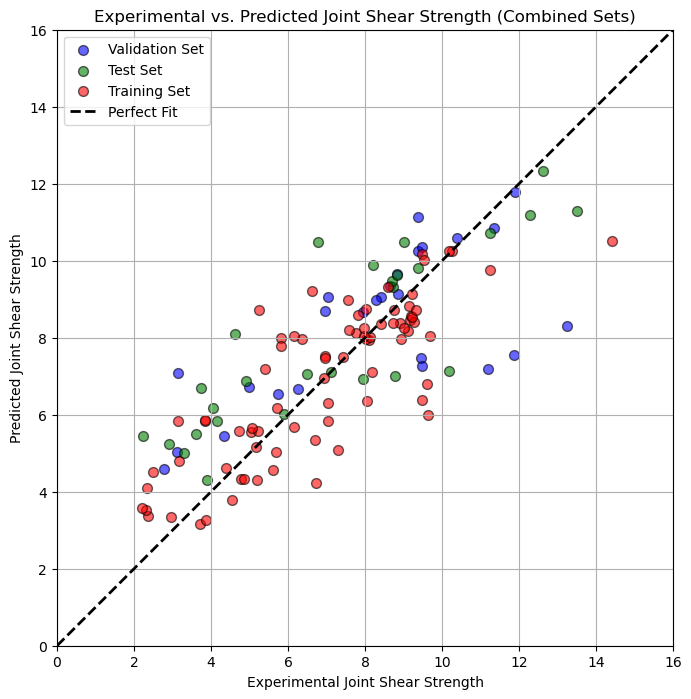

In [411]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# Define jitter function to reduce overlapping points
def add_jitter(values, scale=0.05):
    return values + np.random.uniform(-scale, scale, size=values.shape)

# Reading the Excel file with column names from the first row
data = pd.read_excel('son.xlsx', header=0)

# Convert relevant columns to numeric to ensure proper data types
columns_to_check = ['n', 'sigcc', 'RI', 'jar', 'fy', 'rogross', 'gamma', 'jointtype']
for col in columns_to_check:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Calculating the terms for the specified equation format using gamma from the dataset
data['term_1_n_fc'] = data['gamma'] * (1 + 0.3 * data['n']) * data['sigcc']  # C1 * gamma * (1 + 0.3 * n) * sigcc
data['term_RI_fc'] = data['RI'] * data['sigcc'] / data['jar']  # C2 * RI * sigcc / jar
data['term_fy_A0'] = data['gamma'] * data['fy'] * data['rogross']  # C3 * gamma * fy * rogross

# Selecting the terms for the model
X = data[['term_1_n_fc', 'term_RI_fc', 'term_fy_A0']]
y = data['vj']

# Shuffle the dataset for randomness
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate the number of rows for each subset
total_rows = data_shuffled.shape[0]
train_size = int(0.6 * total_rows)  # 60% for training
val_size = int(0.2 * total_rows)    # 20% for validation
test_size = total_rows - train_size - val_size  # 20% for test

# Manually slicing the dataset
X_train = data_shuffled.iloc[:train_size][['term_1_n_fc', 'term_RI_fc', 'term_fy_A0']]
y_train = data_shuffled.iloc[:train_size]['vj']

X_val = data_shuffled.iloc[train_size:train_size + val_size][['term_1_n_fc', 'term_RI_fc', 'term_fy_A0']]
y_val = data_shuffled.iloc[train_size:train_size + val_size]['vj']

X_test = data_shuffled.iloc[train_size + val_size:][['term_1_n_fc', 'term_RI_fc', 'term_fy_A0']]
y_test = data_shuffled.iloc[train_size + val_size:]['vj']

# Creating and training the final linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Extracting the coefficients
C1, C2, C3 = model.coef_

# Making predictions using the 'production' approach for validation, test, and entire dataset
y_val_pred_production = (
    C1 * X_val['term_1_n_fc'] + 
    C2 * X_val['term_RI_fc'] + 
    C3 * X_val['term_fy_A0']
)
y_test_pred_production = (
    C1 * X_test['term_1_n_fc'] + 
    C2 * X_test['term_RI_fc'] + 
    C3 * X_test['term_fy_A0']
)
y_all_pred_production = (
    C1 * X['term_1_n_fc'] + 
    C2 * X['term_RI_fc'] + 
    C3 * X['term_fy_A0']
)

# Calculating performance metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mpae = mean_absolute_percentage_error(y_true, y_pred) * 100
    r = np.corrcoef(y_true, y_pred)[0, 1]  # Correlation coefficient
    r2 = r2_score(y_true, y_pred)          # R-squared
    return mse, rmse, mpae, r, r2

# Metrics for validation, test, and entire dataset
mse_val, rmse_val, mpae_val, r_val, r2_val = calculate_metrics(y_val, y_val_pred_production)
mse_test, rmse_test, mpae_test, r_test, r2_test = calculate_metrics(y_test, y_test_pred_production)
mse_all, rmse_all, mpae_all, r_all, r2_all = calculate_metrics(y, y_all_pred_production)

# Displaying number of samples
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")
print(f"Number of test samples: {len(X_test)}")

# Tabulating the results for validation, test, and entire dataset
results_df = pd.DataFrame({
    'Set': ['Validation', 'Test', 'Entire Dataset'],
    'MSE': [round(mse_val, 2), round(mse_test, 2), round(mse_all, 2)],
    'RMSE': [round(rmse_val, 2), round(rmse_test, 2), round(rmse_all, 2)],
    'MPAE (%)': [round(mpae_val, 2), round(mpae_test, 2), round(mpae_all, 2)],
    'R': [round(r_val, 2), round(r_test, 2), round(r_all, 2)],
    'R-squared': [round(r2_val, 2), round(r2_test, 2), round(r2_all, 2)]
})
print("\nEvaluation Metrics (Production Approach):")
print(results_df)

# Display the final equation format
print("\nFinal Equation:")
print(f"V_j = [gamma * {C1:.3f} * (1 + 0.3 * n) * sigcc + {C2:.3f} * RI * sigcc / jar + gamma * {C3:.3f} * fy * rogross]")

# Adding jitter for better visualization
y_val_pred_jitter = add_jitter(y_val_pred_production, scale=0.1)
y_test_pred_jitter = add_jitter(y_test_pred_production, scale=0.1)
y_train_pred_jitter = add_jitter(model.predict(X_train), scale=0.1)

# Plotting function
def plot_graph(x, y, title, xlabel, ylabel, color, label):
    plt.figure(figsize=(8, 8))
    plt.scatter(x, y, alpha=0.6, color=color, s=50, edgecolors='k', label=label)
    plt.plot([0, 16], [0, 16], 'k--', lw=2, label='Perfect Fit')
    plt.xlim(0, 16)
    plt.ylim(0, 16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# 1. Plot for validation set
plot_graph(y_val, y_val_pred_jitter, 
           'Experimental vs. Predicted Joint Shear Strength (Validation Set)', 
           'Experimental Joint Shear Strength', 'Predicted Joint Shear Strength', 
           'blue', 'Validation Set')

# 2. Plot for test set
plot_graph(y_test, y_test_pred_jitter, 
           'Experimental vs. Predicted Joint Shear Strength (Test Set)', 
           'Experimental Joint Shear Strength', 'Predicted Joint Shear Strength', 
           'green', 'Test Set')

# 3. Combined plot for validation, test, and training sets
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_val_pred_jitter, alpha=0.6, color='blue', label='Validation Set', s=50, edgecolors='k')
plt.scatter(y_test, y_test_pred_jitter, alpha=0.6, color='green', label='Test Set', s=50, edgecolors='k')
plt.scatter(y_train, y_train_pred_jitter, alpha=0.6, color='red', label='Training Set', s=50, edgecolors='k')
plt.plot([0, 16], [0, 16], 'k--', lw=2, label='Perfect Fit')
plt.xlim(0, 16)
plt.ylim(0, 16)
plt.xlabel('Experimental Joint Shear Strength')
plt.ylabel('Predicted Joint Shear Strength')
plt.title('Experimental vs. Predicted Joint Shear Strength (Combined Sets)')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [413]:
#MULTIPLE LINEAR REGRESSION - METHOD 2 - MECHANICALLY INCONSISTENT


Performance Metrics:
          Set       MSE      RMSE        R²   MPAE (%)
0    Training  1.681396  1.296687  0.799654  18.117909
1  Validation  1.904563  1.380059  0.486022  15.512926
2        Test  2.068260  1.438145  0.724727  17.828617

Optimized Coefficients:
sigcc: 1.366
Vf: 50.593
AR: 0.005
bb: 0.018
bc: -0.011
hb: -0.024
hc: 0.022
n: 3.880
fy: 0.001
rogross: -0.000

Final Equation:
V_j = gamma * [1.366 * sigcc + 50.593 * Vf + 0.005 * AR + 0.018 * bb + -0.011 * bc + -0.024 * hb + 0.022 * hc + 3.880 * n + 0.001 * fy + -0.000 * rogross]


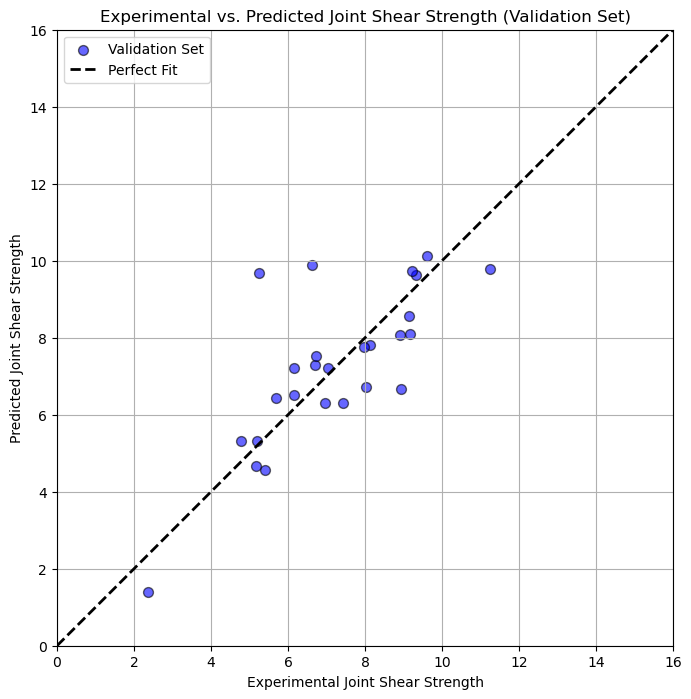

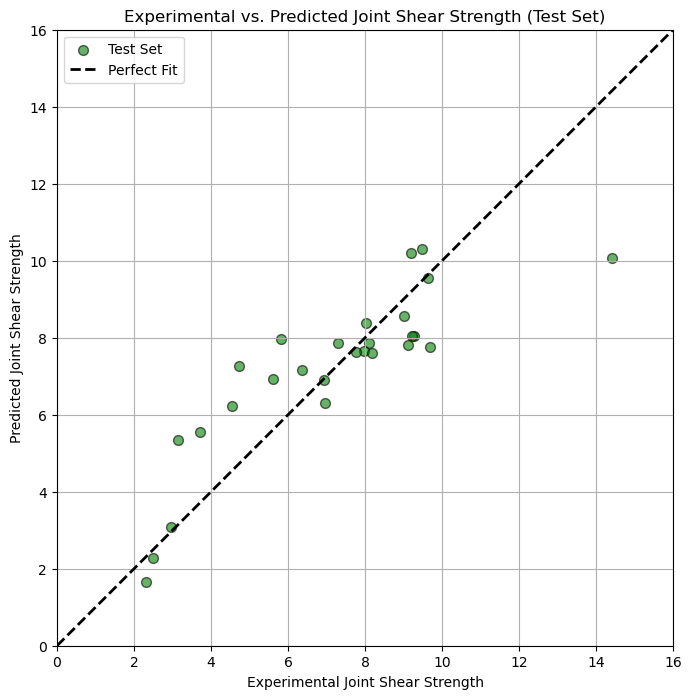

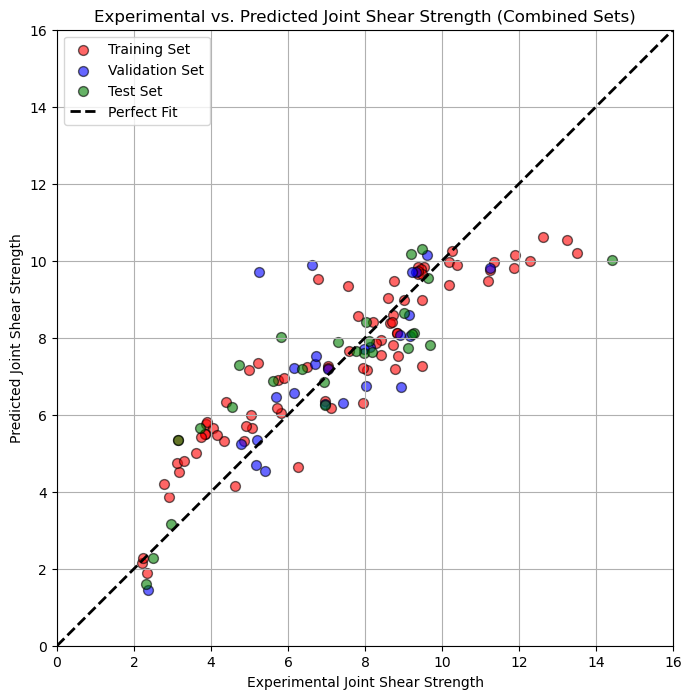

In [415]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define jitter function to reduce overlapping points
def add_jitter(values, scale=0.05):
    return values + np.random.uniform(-scale, scale, size=values.shape)

# Reading the Excel file with column names from the first row
data = pd.read_excel('son.xlsx', header=0)

# Convert relevant columns to numeric to ensure proper data types
columns_to_check = ['sigcc', 'Vf', 'AR', 'bb', 'bc', 'hb', 'hc', 'n', 'fy', 'rogross', 'gamma']
for col in columns_to_check:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Selecting the input features and the output
X = data[['sigcc', 'Vf', 'AR', 'bb', 'bc', 'hb', 'hc', 'n', 'fy', 'rogross']]
y = data['vj']
gamma = data['gamma']

# Define a function to fit linear regression with non-negative constraints
def constrained_linear_regression(X, y, gamma):
    # Initial guess for coefficients
    initial_coeffs = np.ones(X.shape[1])

    # Define the objective function (MSE)
    def objective_function(coeffs):
        preds = gamma * np.dot(X, coeffs)
        mse = mean_squared_error(y, preds)
        return mse

    # Constraints: non-negative coefficients for specific variables
    constraints = [{'type': 'ineq', 'fun': lambda coeffs: coeffs[i]} 
                   for i in [0, 1, 2, 9]]  # Indices for 'sigcc', 'Vf', 'AR', 'rogross'

    # Minimize the objective function with constraints
    result = minimize(objective_function, initial_coeffs, constraints=constraints)

    return result.x  # Return the optimized coefficients

# Fit the model with constraints
optimized_coeffs = constrained_linear_regression(X, y, gamma)

# Calculating predictions for the entire dataset using the production equation
y_pred_production = gamma * np.dot(X, optimized_coeffs)

# Splitting the data into training, validation, and test sets (60/20/20)
X_train, X_temp, y_train, y_temp, gamma_train, gamma_temp = train_test_split(
    X, y, gamma, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test, gamma_val, gamma_test = train_test_split(
    X_temp, y_temp, gamma_temp, test_size=0.5, random_state=42)

# Predictions for validation and test sets
y_train_pred = gamma_train * np.dot(X_train, optimized_coeffs)
y_val_pred = gamma_val * np.dot(X_val, optimized_coeffs)
y_test_pred = gamma_test * np.dot(X_test, optimized_coeffs)

# Calculating performance metrics for validation and test sets
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)
mpae_val = np.mean(np.abs((y_val - y_val_pred) / y_val) * 100)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)
mpae_test = np.mean(np.abs((y_test - y_test_pred) / y_test) * 100)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
mpae_train = np.mean(np.abs((y_train - y_train_pred) / y_train) * 100)

# Print the performance metrics and the coefficients
print("\nPerformance Metrics:")
results_df = pd.DataFrame({
    'Set': ['Training', 'Validation', 'Test'],
    'MSE': [mse_train, mse_val, mse_test],
    'RMSE': [rmse_train, rmse_val, rmse_test],
    'R²': [r2_train, r2_val, r2_test],
    'MPAE (%)': [mpae_train, mpae_val, mpae_test]
})
print(results_df)

print("\nOptimized Coefficients:")
coeff_names = ['sigcc', 'Vf', 'AR', 'bb', 'bc', 'hb', 'hc', 'n', 'fy', 'rogross']
for name, coeff in zip(coeff_names, optimized_coeffs):
    print(f"{name}: {coeff:.3f}")

print("\nFinal Equation:")
equation_terms = " + ".join([f"{coeff:.3f} * {name}" for coeff, name in zip(optimized_coeffs, coeff_names)])
print(f"V_j = gamma * [{equation_terms}]")

# Plotting function for validation, test, and training sets
def plot_results(y_true, y_pred, title, color, label):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, add_jitter(y_pred), alpha=0.6, color=color, label=label, s=50, edgecolors='k')
    plt.plot([0, 16], [0, 16], 'k--', lw=2, label='Perfect Fit')
    plt.xlim(0, 16)
    plt.ylim(0, 16)
    plt.xlabel('Experimental Joint Shear Strength')
    plt.ylabel('Predicted Joint Shear Strength')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Plotting validation and test results
plot_results(y_val, y_val_pred, 'Experimental vs. Predicted Joint Shear Strength (Validation Set)', 'blue', 'Validation Set')
plot_results(y_test, y_test_pred, 'Experimental vs. Predicted Joint Shear Strength (Test Set)', 'green', 'Test Set')

# Combined plot for training, validation, and test sets
plt.figure(figsize=(8, 8))
plt.scatter(y_train, add_jitter(y_train_pred), alpha=0.6, color='red', label='Training Set', s=50, edgecolors='k')
plt.scatter(y_val, add_jitter(y_val_pred), alpha=0.6, color='blue', label='Validation Set', s=50, edgecolors='k')
plt.scatter(y_test, add_jitter(y_test_pred), alpha=0.6, color='green', label='Test Set', s=50, edgecolors='k')
plt.plot([0, 16], [0, 16], 'k--', lw=2, label='Perfect Fit')
plt.xlim(0, 16)
plt.ylim(0, 16)
plt.xlabel('Experimental Joint Shear Strength')
plt.ylabel('Predicted Joint Shear Strength')
plt.title('Experimental vs. Predicted Joint Shear Strength (Combined Sets)')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
